In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión xgboost: {xgboost.__version__}")
print(f"{color}Versión catboost: {catboost.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.5.1
Versión lightgbm: 4.5.0
Versión xgboost: 2.1.1
Versión catboost: 1.2.7
Versión pandas: 2.2.2
Versión numpy: 1.26.4


# BASE MODEL EXAMPLE

In [5]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


In [6]:
# Preprocesado de datos (estableciendo índice y frecuencia)
# ==============================================================================
datos = datos[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('date_time')
datos = datos.asfreq('H')
datos = datos.sort_index()
datos.head()

C:\Users\pms_l\AppData\Local\Temp\ipykernel_79688\537241242.py:6: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,users,holiday,weather,temp,atemp,hum,windspeed
date_time,,,,,,,
2011-01-01 00:00:00,16.0,0.0,clear,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,40.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,32.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,13.0,0.0,clear,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,clear,9.84,14.395,75.0,0.0


In [7]:
# Separación de datos en entrenamiento, validación y test
# ==============================================================================
fin_train = '2012-03-31 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]
print(
    f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
    f"(n={len(datos_train)})"
)
print(
    f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
    f"(n={len(datos_val)})"
)
print(
    f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
    f"(n={len(datos_test)})"
)

Fechas train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Fechas validación : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


# Exploración gráfica

## Representación de la serie temporal

In [8]:
# Gráfico interactivo de la serie temporal
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=datos_train.index, y=datos_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=datos_val.index, y=datos_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Número de usuarios de bicicletas',
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    legend_title="Partición:",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

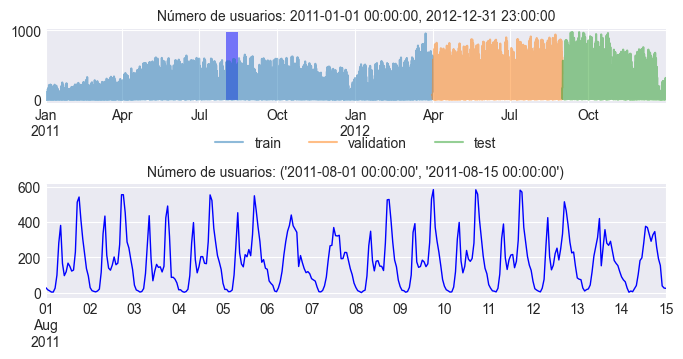

In [9]:
# Gráfico de la serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
datos_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
datos_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['users'])
max_y = max(datos['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
datos.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Número de usuarios: {datos.index.min()}, {datos.index.max()}', fontsize=10)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

## Gráficos de estacionalidad

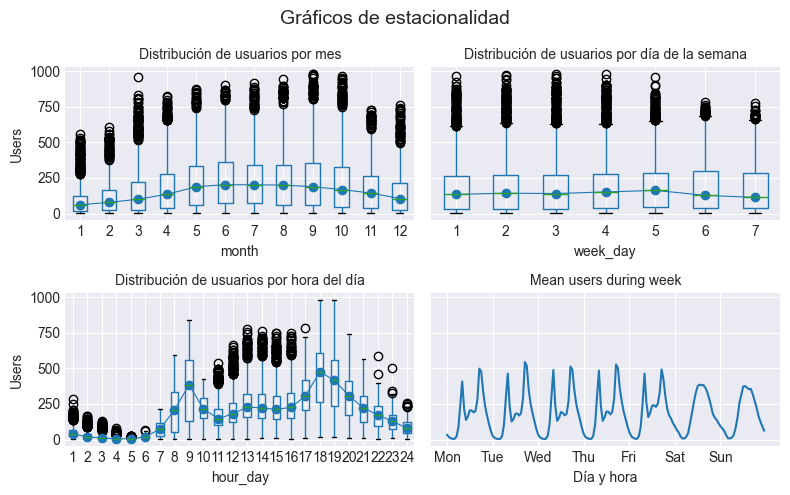

In [10]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribusión de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column='users', by='month', ax=axs[0])
datos.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Distribución de usuarios por mes', fontsize=10)

# Distribusión de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column='users', by='week_day', ax=axs[1])
datos.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Distribución de usuarios por día de la semana', fontsize=10)

# Distribusión de usuarios por hora del día
datos['hour_day'] = datos.index.hour + 1
datos.boxplot(column='users', by='hour_day', ax=axs[2])
datos.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Distribución de usuarios por hora del día', fontsize=10)

# Distribusión de usuarios por día de la semana y hora del día
mean_day_hour = datos.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "Users"
)
axs[3].title.set_size(10)

fig.suptitle("Gráficos de estacionalidad", fontsize=14)
fig.tight_layout()

## Gráficos de autocorrelación

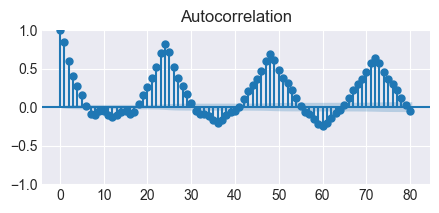

In [11]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos['users'], ax=ax, lags=80)
plt.show()

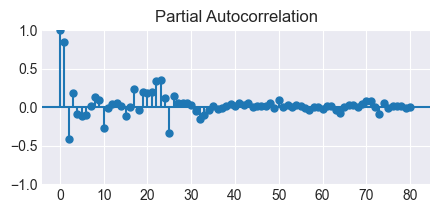

In [12]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos['users'], ax=ax, lags=80, method='ywm')
plt.show()

# Baseline

In [13]:
# Crear un baseline: valor de la misma hora del día anterior
# ==============================================================================
forecaster = ForecasterEquivalentDate(
    offset    = pd.DateOffset(days=1),
    n_offsets = 1
)

# Entremaiento del forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2024-09-26 23:32:09 
Last fit date: 2024-09-26 23:32:09 
Skforecast version: 0.13.0 
Python version: 3.12.6 
Forecaster id: None 

In [14]:
# Backtesting
# ==============================================================================
metrica_baseline, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos.loc[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_baseline

  0%|          | 0/82 [00:00<?, ?it/s]

,mean_absolute_error
0,91.668716


# Modelo autoregresivo recursivo con LightGBM

LightGBM es una implementación altamente eficiente del algoritmo gradient boosting, que se ha convertido en un referente en el campo del machine learning. La librería LightGBM incluye su propia API, así como la API de scikit-learn, lo que la hace compatible con skforecast.

En primer lugar, se entrena un modelo ForecasterAutoreg utilizando valores pasados de la variable de respuesta (lags) como predictores. Posteriormente, se añaden variables exógenas al modelo y se evalúa la mejora de su rendimiento. Dado que los modelos de Gradient Boosting tienen un gran número de hiperparámetros, se realiza una Búsqueda Bayesiana utilizando la función bayesian_search_forecaster() para encontrar la mejor combinación de hiperparámetros y lags. Por último, se evalúa la capacidad predictiva del modelo mediante un proceso de backtesting.

## Forecaster

In [15]:
# Crear el forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=15926, verbose=-1),
    lags      = 24
)

# Entrenar el forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-09-26 23

In [16]:
# Predicciones
# ==============================================================================
forecaster.predict(steps=10)

2012-09-01 00:00:00    110.553303
2012-09-01 01:00:00     75.218776
2012-09-01 02:00:00     42.928564
2012-09-01 03:00:00     24.890883
2012-09-01 04:00:00     10.654948
2012-09-01 05:00:00     16.922900
2012-09-01 06:00:00     41.333408
2012-09-01 07:00:00     92.882118
2012-09-01 08:00:00    221.375747
2012-09-01 09:00:00    374.074368
Freq: h, Name: pred, dtype: float64

## Backtesting

Para obtener una estimación robusta de la capacidad predictiva del modelo, se realiza un proceso de backtesting. El proceso de backtesting consiste en generar una predicción para cada observación del conjunto de test, siguiendo el mismo procedimiento que se seguiría si el modelo estuviese en producción, y finalmente comparar el valor predicho con el valor real.

In [17]:
# Backtest del modelo con lo datos de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = True, # Cambiar a False para mostrar menos información
    show_progress      = True
)
predicciones.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 14616
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 12 observations.

Fold: 0
    Training:   2011-01-01 00:00:00 -- 2012-08-31 23:00:00  (n=14616)
    Validation: 2012-09-01 00:00:00 -- 2012-09-02 11:00:00  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 2012-09-02 12:00:00 -- 2012-09-03 23:00:00  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 2012-09-04 00:00:00 -- 2012-09-05 11:00:00  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 2012-09-05 12:00:00 -- 2012-09-06 23:00:00  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 2012-09-07 00:00:00 -- 2012-09-08 11:00:00  (n=36)


  0%|          | 0/82 [00:00<?, ?it/s]

,pred
2012-09-01 00:00:00,110.553303
2012-09-01 01:00:00,75.218776
2012-09-01 02:00:00,42.928564
2012-09-01 03:00:00,24.890883
2012-09-01 04:00:00,10.654948


In [18]:
# Error de backtest
# ==============================================================================
metrica

,mean_absolute_error
0,76.258681


# Optimización de hiperparámetros (tuning)

El ForecasterAutoreg entrenado utiliza los primeros 24 lags y un modelo LGMBRegressor con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para encontrar los mejores hiperparámetros, se realiza una Búsqueda Bayesiana con la función bayesian_search_forecaster(). La búsqueda se lleva a cabo utilizando el mismo proceso de backtesting que antes, pero cada vez, el modelo se entrena con diferentes combinaciones de hiperparámetros y lags. Es importante señalar que la búsqueda de hiperparámetros debe realizarse utilizando el conjunto de validación, nunca con los datos de test.

La búsqueda se realiza probando cada combinación de hiperparámetros y retardos del siguiente modo:

Entrenar el modelo utilizando sólo el conjunto de entrenamiento.

El modelo se evalúa utilizando el conjunto de validación mediante backtesting.

Seleccionar la combinación de hiperparámetros y retardos que proporcione el menor error.

Volver a entrenar el modelo con la mejor combinación encontrada, esta vez utilizando tanto los datos de entrenamiento como los de validación.
Siguiendo estos pasos, se puede obtener un modelo con hiperparámetros optimizados y evitar el sobreajuste.

In [19]:
# Búsqueda de hiperparámetros
# ==============================================================================
# Lags candidatos
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

resultados_busqueda, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'], # Datos test no incluidos
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20, # Aumentar para una búsqueda más exhaustiva
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1100, 'max_depth': 8, 'min_data_in_leaf': 425, 'learning_rate': 0.07002735285634534, 'feature_fraction': 0.6, 'max_bin': 75, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004}
  Backtesting metric: 68.33537644642092



In [20]:
# Resultados de la búsqueda
# ==============================================================================
resultados_busqueda.head(10)

,lags,params,mean_absolute_error,n_estimators,max_depth,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
19,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1100, 'max_depth': 8, 'min_da...",68.335376,1100.0,8.0,425.0,0.070027,0.6,75.0,0.4,0.3
14,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",69.194709,1200.0,10.0,464.0,0.137025,0.9,75.0,0.2,0.3
15,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 900, 'max_depth': 8, 'min_dat...",69.316631,900.0,8.0,460.0,0.144455,0.8,100.0,0.2,0.4
1,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1000, 'max_depth': 6, 'min_da...",69.399878,1000.0,6.0,53.0,0.205042,0.9,75.0,0.1,0.5
10,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",69.587667,1200.0,10.0,47.0,0.013950,1.0,50.0,0.0,0.2
3,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 6, 'min_dat...",69.668446,800.0,6.0,173.0,0.218912,1.0,250.0,0.5,0.6
17,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 400, 'max_depth': 8, 'min_dat...",70.008581,400.0,8.0,491.0,0.131761,0.8,100.0,0.2,0.4
13,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 900, 'max_depth': 8, 'min_dat...",70.130838,900.0,8.0,207.0,0.363259,1.0,75.0,0.0,0.0
16,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 9, 'min_dat...",70.142015,800.0,9.0,493.0,0.119178,0.6,125.0,0.3,0.4
11,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",70.276072,1200.0,10.0,31.0,0.017627,1.0,50.0,0.0,0.2


In [21]:
# Mejor modelo
# ==============================================================================
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(feature_fraction=0.6, learning_rate=0.07002735285634534,
              max_bin=75, max_depth=8, min_data_in_leaf=425, n_estimators=1100,
              random_state=15926, reg_alpha=0.4, reg_lambda=0.30000000000000004,
              verbose=-1) 
Lags: [  1   2   3  23  24  25 167 168 169] 
Transformer for y: None 
Transformer for exog: None 
Window size: 169 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.07002735285634534, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1100, 'n_jobs': None, 'num_leaves': 31, 'objective': N

## Backtesting con datos de test

In [22]:
# Backtest modelo final con datos de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
display(metrica)
predicciones.head()

  0%|          | 0/82 [00:00<?, ?it/s]

,mean_absolute_error
0,67.373324


,pred
2012-09-01 00:00:00,131.093298
2012-09-01 01:00:00,97.258305
2012-09-01 02:00:00,65.512600
2012-09-01 03:00:00,34.881848
2012-09-01 04:00:00,10.742675


In [23]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

# Variables exógenas

Hasta ahora, sólo se han utilizado como predictores los valores pasados (lags) de la serie temporal. Sin embargo, es posible incluir otras variables como predictores. Estas variables se conocen como variables exógenas (features) y su uso puede mejorar la capacidad predictiva del modelo. Un punto muy importante que hay que tener en cuenta es que los valores de las variables exógenas deben conocerse en el momento de la predicción.

Ejemplos habituales de variables exógenas son aquellas obtenidas del calendario, como el día de la semana, el mes, el año o los días festivos. Las variables meteorológicas como la temperatura, la humedad y el viento también entran en esta categoría, al igual que las variables económicas como la inflación y los tipos de interés

## Variables de calendario y meteorológicas

A continuación, se crean variables exógenas basadas en información del calendario, las horas de salida y puesta del sol, la temperatura y los días festivos. Estas nuevas variables se añaden a los conjuntos de entrenamiento, validación y test, y se utilizan como predictores en el modelo autorregresivo

In [24]:
# Variables basadas en el calendario
# ==============================================================================
variables_calendario = pd.DataFrame(index=datos.index)
variables_calendario['mes'] = variables_calendario.index.month
variables_calendario['semana_anyo'] = variables_calendario.index.isocalendar().week
variables_calendario['dia_semana'] = variables_calendario.index.day_of_week + 1
variables_calendario['hora_dia'] = variables_calendario.index.hour + 1

# Variables basadas en la luz solar
# ==============================================================================
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
hora_amanecer = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in datos.index
]
hora_anochecer = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in datos.index
]
variables_solares = pd.DataFrame({
                         'hora_amanecer': hora_amanecer,
                         'hora_anochecer': hora_anochecer}, 
                         index = datos.index
                     )
variables_solares['horas_luz_solar'] = (
    variables_solares['hora_anochecer'] - variables_solares['hora_amanecer']
)
variables_solares["es_de_dia"] = np.where(
    (datos.index.hour >= variables_solares["hora_amanecer"])
    & (datos.index.hour < variables_solares["hora_anochecer"]),
    1,
    0,
)

# Variables basadas en festivos
# ==============================================================================
variables_festivos = datos[['holiday']].astype(int)
variables_festivos['holiday_dia_anterior'] = variables_festivos['holiday'].shift(24)
variables_festivos['holiday_dia_siguiente'] = variables_festivos['holiday'].shift(-24)

# Variables basadas en temperatura
# ==============================================================================
variables_temp = datos[['temp']].copy()
variables_temp['temp_roll_mean_1_dia'] = variables_temp['temp'].rolling(24, closed='left').mean()
variables_temp['temp_roll_mean_7_dia'] = variables_temp['temp'].rolling(24*7, closed='left').mean()
variables_temp['temp_roll_max_1_dia'] = variables_temp['temp'].rolling(24, closed='left').max()
variables_temp['temp_roll_min_1_dia'] = variables_temp['temp'].rolling(24, closed='left').min()
variables_temp['temp_roll_max_7_dia'] = variables_temp['temp'].rolling(24*7, closed='left').max()
variables_temp['temp_roll_min_7_dia'] = variables_temp['temp'].rolling(24*7, closed='left').min()


# Merge all exogenous variables
# ==============================================================================
variables_exogenas = pd.concat([
    variables_calendario,
    variables_solares,
    variables_temp,
    variables_festivos
], axis=1)

variables_exogenas.head(4)

,mes,semana_anyo,dia_semana,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,temp,temp_roll_mean_1_dia,temp_roll_mean_7_dia,temp_roll_max_1_dia,temp_roll_min_1_dia,temp_roll_max_7_dia,temp_roll_min_7_dia,holiday,holiday_dia_anterior,holiday_dia_siguiente
date_time,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 03:00:00,1,52,6,4,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0


## Variables con patrones cíclicos

Algunos aspectos del calendario, como las horas o los días, son cíclicos. Por ejemplo, la hora del día va de 0 a 23 horas. Este tipo de variables pueden tratarse de varias formas, cada una con sus ventajas e inconvenientes.

Un enfoque consiste en utilizar las variables directamente como valores numéricos sin ninguna transformación. Este método evita crear variables nuevas, pero puede imponer un orden lineal incorrecto a los valores. Por ejemplo, la hora 23 de un día y la hora 00 del siguiente están muy alejadas en su representación lineal, cuando en realidad sólo hay una hora de diferencia entre ellas.

Otra posibilidad es tratar las variables cíclicas como variables categóricas para evitar imponer un orden lineal. Sin embargo, este enfoque puede provocar la pérdida de la información cíclica inherente a la variable.

Existe una tercera forma de tratar las variables cíclicas que suele preferirse a los otros dos métodos. Se trata de transformar las variables utilizando el seno y el coseno de su periodo. Este método genera solo dos nuevas variables que captan la ciclicidad de los datos con mayor precisión que los dos métodos anteriores, ya que preserva el orden natural de la variable y evita imponer un orden lineal.

In [25]:
# Codificación cíclica de las variables de calendario y luz solar
# ==============================================================================
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    """
    Codifica una variable cíclica con dos nuevas variables: seno y coseno.
    Se asume que el valor mínimo de la variable es 0. El valor máximo de la
    variable se pasa como argumento.
      
    Parameters
    ----------
    datos : pd.Series
        Serie con la variable a codificar.
    longitud_ciclo : int
        La longitud del ciclo. Por ejemplo, 12 para meses, 24 para horas, etc.
        Este valor se utiliza para calcular el ángulo del seno y coseno.

    Returns
    -------
    resultado : pd.DataFrame
        Dataframe con las dos nuevas características: seno y coseno.

    """

    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado


mes_encoded = codificacion_ciclica(variables_exogenas['mes'], longitud_ciclo=12)
semana_anyo_encoded = codificacion_ciclica(variables_exogenas['semana_anyo'], longitud_ciclo=52)
dia_semana_encoded = codificacion_ciclica(variables_exogenas['dia_semana'], longitud_ciclo=7)
hora_dia_encoded = codificacion_ciclica(variables_exogenas['hora_dia'], longitud_ciclo=24)
hora_amanecer_encoded = codificacion_ciclica(variables_exogenas['hora_amanecer'], longitud_ciclo=24)
hora_anochecer_encoded = codificacion_ciclica(variables_exogenas['hora_anochecer'], longitud_ciclo=24)

variables_ciclicas = pd.concat([
                            mes_encoded,
                            semana_anyo_encoded,
                            dia_semana_encoded,
                            hora_dia_encoded,
                            hora_amanecer_encoded,
                            hora_anochecer_encoded
                        ], axis=1)  

variables_exogenas = pd.concat([variables_exogenas, variables_ciclicas], axis=1)
variables_exogenas.head(3)

,mes,semana_anyo,dia_semana,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,temp,temp_roll_mean_1_dia,...,semana_anyo_seno,semana_anyo_coseno,dia_semana_seno,dia_semana_coseno,hora_dia_seno,hora_dia_coseno,hora_amanecer_seno,hora_amanecer_coseno,hora_anochecer_seno,hora_anochecer_coseno
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,...,0.0,1.0,-0.781831,0.62349,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,...,0.0,1.0,-0.781831,0.62349,0.500000,0.866025,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,...,0.0,1.0,-0.781831,0.62349,0.707107,0.707107,0.965926,-0.258819,-0.866025,-0.5


## Interacción entre variables

En muchos casos, las variables exógenas no son independientes. Más bien, su efecto sobre la variable objetivo depende del valor de otras variables. Por ejemplo, el efecto de la temperatura en la demanda de electricidad depende de la hora del día. La interacción entre las variables exógenas puede captarse mediante nuevas variables que se obtienen multiplicando entre sí las variables existentes. Estas interacciones se obtienen fácilmente con la clase PolynomialFeatures de scikit-learn.



In [26]:
# Interacción entre variables exógenas
# ==============================================================================
transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
).set_output(transform="pandas")

poly_cols = [
    'mes_seno',
    'mes_coseno',
    'semana_anyo_seno',
    'semana_anyo_coseno',
    'dia_semana_seno',
    'dia_semana_coseno',
    'hora_dia_seno',
    'hora_dia_coseno',
    'hora_amanecer_seno',
    'hora_amanecer_coseno',
    'hora_anochecer_seno',
    'hora_anochecer_coseno',
    'horas_luz_solar',
    'es_de_dia',
    'holiday_dia_anterior',
    'holiday_dia_siguiente',
    'temp_roll_mean_1_dia',
    'temp_roll_mean_7_dia',
    'temp_roll_max_1_dia',
    'temp_roll_min_1_dia',
    'temp_roll_max_7_dia',
    'temp_roll_min_7_dia',
    'temp',
    'holiday'
]

variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols].dropna())
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.head(3)

,mes,semana_anyo,dia_semana,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,temp,temp_roll_mean_1_dia,...,poly_temp_roll_min_1_dia__temp_roll_max_7_dia,poly_temp_roll_min_1_dia__temp_roll_min_7_dia,poly_temp_roll_min_1_dia__temp,poly_temp_roll_min_1_dia__holiday,poly_temp_roll_max_7_dia__temp_roll_min_7_dia,poly_temp_roll_max_7_dia__temp,poly_temp_roll_max_7_dia__holiday,poly_temp_roll_min_7_dia__temp,poly_temp_roll_min_7_dia__holiday,poly_temp__holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variables categóricas

Existen varios enfoques para incorporar variables categóricas en LightGBM (y otras implementaciones de gradient boosting):

Una opción es transformar los datos convirtiendo los valores categóricos en valores numéricos utilizando métodos como la codificación one hot la codificación ordinal. Este enfoque es aplicable a todos los modelos de aprendizaje automático.

LightGBM puede manejar variables categóricas internamente sin necesidad de preprocesamiento. Esto puede hacerse automáticamente estableciendo el parámetro categorical_features='auto' y almacenando las variables con el tipo de dato category dentro de un Pandas DataFrame. Tambien es posible especificar los nombres de las variables a tratar como categóricas pasando una lista de nombres al parámetro categorical_features.

No hay un método que sea siempre mejor que los otros. Las reglas generales son:

Cuando la cardinalidad de las variables categóricas es alta (muchos valores diferentes), es mejor utilizar el soporte nativo para variables categóricas que utilizar la codificación one-hot.

Con datos codificados con one hot encoding, se necesitan más puntos de división (es decir, más profundidad) para recuperar una división equivalente a la que podría obtenerse con un solo punto de división utilizando el tratamiento nativo.

Cuando una variable categórica se convierte en múltiples variables dummy utilizando one hot encoding, su importancia se diluye, haciendo que el análisis de la importancia de las características sea más complejo de interpretar.

In [27]:
# Almacenar las variables categoricas como tipo "category"
# ==============================================================================
datos["weather"] = datos["weather"].astype("category")

### One hot encoding

ColumnTransformers en scikit-learn proporcionan una potente forma de definir transformaciones y aplicarlas a variables específicas. Al encapsular las transformaciones en un objeto ColumnTransformer, se puede pasar a un Forecaster utilizando el argumento transformer_exog

In [28]:
# Transformación con codificación one-hot
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")  

In [29]:
# Crear un forecaster con un transformer para las variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = one_hot_encoder
)

In [30]:
# Mostrar matrices de entrenamiento
# ==============================================================================
exog_cols = ['weather']        
X_train, y_train = forecaster.create_train_X_y(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,weather_clear,weather_mist,weather_rain
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-04 00:00:00,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,72.0,77.0,...,2.0,1.0,1.0,13.0,32.0,40.0,16.0,1.0,0.0,0.0
2011-01-04 01:00:00,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,72.0,...,3.0,2.0,1.0,1.0,13.0,32.0,40.0,1.0,0.0,0.0
2011-01-04 02:00:00,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,...,8.0,3.0,2.0,1.0,1.0,13.0,32.0,1.0,0.0,0.0


### Implementación nativa para variables categóricas

Las librerías de Gradient Boosting (XGBoost, LightGBM, CatBoost y HistGradientBoostingRegressor) asumen que las variables de entrada son números enteros empezando por 0 hasta el número de categorías [0, 1, ..., n_categories-1]. En la mayoría de los casos reales, las variables categóricas no se codifican con números sino con cadenas (strings), por lo que es necesario un paso intermedio de transformación. Existen dos opciones:

Asignar a las columnas con variables categóricas el tipo category. Internamente, esta estructura de datos consiste en una matriz de categorías y una matriz de valores enteros (códigos) que apuntan al valor real de la matriz de categorías. Es decir, internamente es una matriz numérica con un mapeo que relaciona cada valor con una categoría. Los modelos son capaces de identificar automáticamente las columnas de tipo category y acceder a sus códigos internos. Este enfoque es aplicable a XGBoost, LightGBM y CatBoost.

Preprocesar las columnas categóricas con un OrdinalEncoder para transformar sus valores a enteros y luego indicar explícitamente que deben ser tratadas como categóricas.

Para utilizar la detección automática en skforecast, las variables categóricas deben codificarse primero como enteros y luego almacenarse de nuevo como tipo category. Esto se debe a que skforecast utiliza internamente una matriz numérica numpy para acelerar el cálculo

In [31]:
# Transformación: codificación ordinal + conversión a tipo "category"
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [32]:
# Crear un forecaster con detección automática de variables categóricas (LGBMRegressor)
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

## Evaluar el modelo con variables exógenas

In [33]:
# Selección de variables exógenas a incluir en el modelo
# ==============================================================================
exog_cols = []
# Columnas que terminan con _seno o _coseno son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='_seno$|_coseno$').columns.tolist())
# Columnas que empiezan con tem_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^temp_.*').columns.tolist())
# Columnas que empiezan con holiday_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^holiday_.*').columns.tolist())
exog_cols.extend(['temp', 'holiday', 'weather'])

variables_exogenas = variables_exogenas.filter(exog_cols, axis=1)

In [35]:
# Combinar variables exógenas y target en el mismo dataframe
# ==============================================================================
datos = datos[['users', 'weather']].merge(
    variables_exogenas,
    left_index=True,
    right_index=True,
    how='left'
)

# Debido a la creación de medias móviles, hay valores NaN al principio de la serie.
# Debido a holiday_dia_siguiente hay valores NaN al final de la serie.
# Las columnas numéricas se convierten a float32.
datos = datos.dropna()
datos = datos.astype({col: np.float32 for col in datos.select_dtypes("number").columns})
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

In [36]:
# Búsqueda de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Lags grid
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 800, 'max_depth': 9, 'min_data_in_leaf': 269, 'learning_rate': 0.010035818244859579, 'feature_fraction': 0.6, 'max_bin': 50, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
  Backtesting metric: 63.48130784020649



In [37]:
# Backtesting en los datos de test incluyendo las variables exógenas
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_cols],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,53.907985


In [38]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

# Selección de predictores

La selección de predictores (feature selection) es el proceso de identificar un subconjunto de predictores relevantes para su uso en la creación del modelo. Es un paso importante en el proceso de machine learning, ya que puede ayudar a reducir el sobreajuste, mejorar la precisión del modelo y reducir el tiempo de entrenamiento. Dado que los regresores subyacentes de skforecast siguen la API de scikit-learn, es posible utilizar los métodos de selección de predictores disponibles en scikit-learn. Dos de los métodos más populares son Recursive Feature Elimination y Sequential Feature Selection.

In [39]:
# Crear forecaster
# ==============================================================================
regressor = LGBMRegressor(
    n_estimators = 100,
    max_depth = 5,
    random_state = 15926,
    verbose = -1
)

forecaster = ForecasterAutoreg(
    regressor        = regressor,
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Eliminación recursiva de predictores con validación cruzada
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
lags_seleccionados, exog_seleccionadas = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = datos_train['users'],
    exog            = datos_train[exog_cols],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

d:\Apps\Conda\envs\datafest\Lib\site-packages\joblib\_utils.py:37: DeprecationWarning:

ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead

d:\Apps\Conda\envs\datafest\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning:

Attribute n is deprecated and will be removed in Python 3.14; use value instead



Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 10607
Total number of records used for feature selection: 5303
Number of features available: 98
    Autoreg (n=9)
    Exog    (n=89)
Number of features selected: 39
    Autoreg (n=9) : [1, 2, 3, 23, 24, 25, 167, 168, 169]
    Exog    (n=30) : ['weather', 'hora_dia_seno', 'hora_dia_coseno', 'poly_mes_seno__dia_semana_coseno', 'poly_mes_seno__hora_dia_seno', 'poly_mes_coseno__semana_anyo_seno', 'poly_semana_anyo_seno__dia_semana_seno', 'poly_semana_anyo_seno__dia_semana_coseno', 'poly_semana_anyo_seno__hora_dia_seno', 'poly_semana_anyo_seno__hora_dia_coseno', 'poly_semana_anyo_seno__hora_amanecer_coseno', 'poly_semana_anyo_coseno__dia_semana_seno', 'poly_semana_anyo_coseno__dia_semana_coseno', 'poly_semana_anyo_coseno__hora_dia_seno', 'poly_semana_anyo_coseno__hora_dia_coseno', 'poly_semana_anyo_coseno__hora_anochecer_coseno', 'poly_dia_semana_seno__dia_semana_coseno', 'poly_dia

In [40]:
# Crear forecaster con los predictores seleccionados
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags             = lags_seleccionados,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Backtesting con los predictores seleccionados y los datos de test
# ==============================================================================
metrica_lgbm, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_seleccionadas],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_lgbm

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,54.660357


In [41]:
# Actualizar las variables exógenas utilizadas
# ==============================================================================
exog_cols = exog_seleccionadas

# Forecasting probabilístico: intervalos de predicción

Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de la variable respuesta con una determinada probabilidad. Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría los cuales requieren que los resudios (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es uno de los métodos disponibles en skforecast. Se pude encontrar una explicación más detallada de los intervalos de predicción en Probabilistic forecasting: prediction intervals and prediction distribution.

El siguiente código muestra cómo generar intervalos de predicción con un modelo autorregresivo. La función prediction_interval() se utiliza para estimar los intervalos para cada step predicho. Después, se utiliza la función backtesting_forecaster() para generar los intervalos de predicción de todo el conjunto de test. El argumento interval se utiliza para especificar la probabilidad de cobertura deseada de los intervalos. En este caso, interval se establece en [10, 90], lo que significa que los intervalos se calculan con los percentiles 10 y 90, lo que da como resultado una cobertura teórica del 80%. El argumento n_boot se utiliza para especificar el número de iteraciones de bootstraping que se utilizan para estimar los intervalos. Cuanto mayor sea el número de muestras, más precisos serán los intervalos de predicción, pero más tiempo tardará el proceso

In [42]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor          = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags               = 72,
    transformer_exog   = transformer_exog,
    fit_kwargs         = {"categorical_feature": "auto"},
    binner_kwargs      = {"n_bins": 15}
)
forecaster.fit(
    y    = datos.loc[:fin_train, 'users'],
    exog = datos.loc[:fin_train, exog_cols]
)

In [43]:
# Predicción de intervalos
# ==============================================================================
# Como el modelo ha sido entrenado con variables exógenas, se tienen que pasar
# para las predicciones.
predictions = forecaster.predict_interval(
    exog     = datos.loc[fin_train:, exog_cols],
    steps    = 24,
    interval = [10, 90], 
)
predictions.head()

,pred,lower_bound,upper_bound
2012-04-01 00:00:00,80.882086,53.338980,111.542357
2012-04-01 01:00:00,64.337485,29.535426,96.992541
2012-04-01 02:00:00,49.545458,14.947084,106.834280
2012-04-01 03:00:00,23.215475,-4.238424,91.797297
2012-04-01 04:00:00,9.554792,-10.406696,86.343260


In [44]:
# Backtesting con los datos de validación para obtener residuos out-sample
# ==============================================================================
_, predictions_val = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    steps              = 24,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos.loc[:fin_train]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
residuals = datos.loc[predictions_val.index, 'users'] - predictions_val['pred']
residuals = residuals.dropna()


  0%|          | 0/153 [00:00<?, ?it/s]

positive    1971
negative    1701
Name: count, dtype: int64


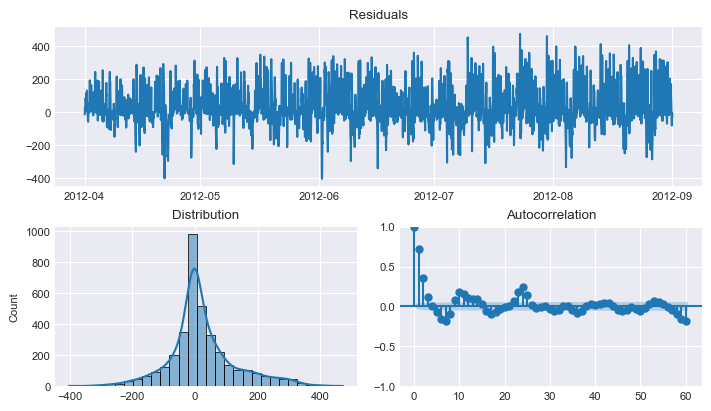

In [45]:
# Distribución de los residuos out-sample
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [46]:
# Almacenar residuos out-sample en el forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    residuals = residuals,
    y_pred    = datos.loc[predictions_val.index, 'users']
)

In [47]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
fin_test = '2012-10-31 23:00:00'
metric, predictions = backtesting_forecaster(
   forecaster          = forecaster,
   y                   = datos.loc[:fin_test, 'users'],
   exog                = datos.loc[:fin_test, exog_cols],
   steps               = 24,
   metric              = 'mean_absolute_error',
   initial_train_size  = len(datos.loc[:fin_validacion]),
   refit               = False,
   interval            = [10, 90],
   n_boot              = 200,
   in_sample_residuals = False, # Use out-sample residuals
   binned_residuals    = True, # Residuals conditioned on predicted values
   n_jobs              = 'auto',
   verbose             = False,
   show_progress       = True
)
predictions.head(5)

  0%|          | 0/61 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-09-01 00:00:00,137.196980,8.365453,166.125249
2012-09-01 01:00:00,96.715579,-98.617089,109.530133
2012-09-01 02:00:00,68.544321,-49.633410,70.942100
2012-09-01 03:00:00,31.625760,-34.303464,32.325934
2012-09-01 04:00:00,8.767094,-11.696622,12.490767


In [48]:
# Plot prediction intervals vs real value
# ==============================================================================
fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=predictions.index,
        y=predictions['pred'],
        mode='lines',
    ),
    go.Scatter(
        name='Real value',
        x=datos_test.loc[:fin_test].index,
        y=datos_test.loc[:fin_test, 'users'],
        mode='lines',
    ),
    go.Scatter(
        name='Upper Bound',
        x=predictions.index,
        y=predictions['upper_bound'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=predictions.index,
        y=predictions['lower_bound'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [49]:
# Cobertura del intervalo en los datos de test
# ==============================================================================
coverage = np.mean(
    np.logical_and(
        datos.loc[fin_validacion:fin_test, 'users'] >= predictions["lower_bound"],
        datos.loc[fin_validacion:fin_test, 'users'] <= predictions["upper_bound"]
    )
)
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Total area of the interval: 356011.31
Predicted interval coverage: 79.44 %


# Explicabilidad del modelo

Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: model-specific feature importances, SHAP values, and partial dependence plots.

In [50]:
# Crear y entrenar el forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags      = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
forecaster.fit(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)

In [51]:
# Extraer importancia de los predictores
# ==============================================================================
importancia = forecaster.get_feature_importances()
importancia.head(10)

,feature,importance
0,lag_1,2951
7,lag_168,1411
8,lag_169,1362
1,lag_2,1106
2,lag_3,1041
10,hora_dia_seno,1034
4,lag_24,897
6,lag_167,869
32,poly_hora_dia_seno__hora_dia_coseno,726
30,poly_dia_semana_coseno__hora_dia_seno,673


## Shap values

Los valores SHAP (SHapley Additive exPlanations) son un método muy utilizado para explicar los modelos de machine learning, ya que ayudan a comprender cómo influyen las variables y los valores en las predicciones de forma visual y cuantitativa.

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

El regresor interno del forecaster.

Las matrices de entrenamiento creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el forecaster.

Aprovechando estos dos componentes, los usuarios pueden crear explicaciones interpretables para sus modelos de skforecast. Estas explicaciones pueden utilizarse para verificar la fiabilidad del modelo, identificar los factores más significativos que contribuyen a las predicciones y comprender mejor la relación subyacente entre las variables de entrada y la variable objetivo.

In [52]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)
display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_23,lag_24,lag_25,lag_167,lag_168,lag_169,weather,...,poly_dia_semana_seno__hora_anochecer_coseno,poly_dia_semana_coseno__hora_dia_seno,poly_dia_semana_coseno__hora_dia_coseno,poly_hora_dia_seno__hora_dia_coseno,poly_hora_dia_seno__hora_anochecer_seno,poly_hora_dia_coseno__hora_amanecer_coseno,poly_hora_dia_coseno__hora_anochecer_seno,temp_roll_mean_1_dia,temp_roll_mean_7_dia,temp
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-15 01:00:00,28.0,27.0,36.0,1.0,5.0,14.0,16.0,16.0,25.0,1,...,0.202353,0.311745,0.539958,0.433013,-0.482963,-0.224144,-0.836516,6.594167,6.535595,6.56
2011-01-15 02:00:00,20.0,28.0,27.0,1.0,1.0,5.0,7.0,16.0,16.0,1,...,0.202353,0.440874,0.440874,0.500000,-0.683013,-0.183013,-0.683013,6.696667,6.530715,6.56
2011-01-15 03:00:00,12.0,20.0,28.0,1.0,1.0,1.0,1.0,7.0,16.0,1,...,0.202353,0.539958,0.311745,0.433013,-0.836516,-0.129410,-0.482963,6.799167,6.525833,6.56


date_time
2011-01-15 01:00:00    20.0
2011-01-15 02:00:00    12.0
2011-01-15 03:00:00     8.0
Freq: h, Name: y, dtype: float32

In [53]:
# Crear SHAP explainer (para modelos basados en árboles)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

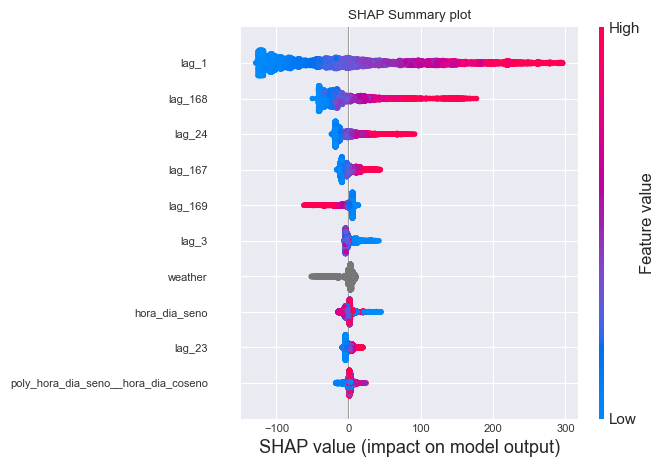

In [54]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [55]:
# Force plot para la primera observación de la muestra
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])

# XGBoost, CatBoost y HistGradientBoostingRegressor

Desde el éxito del Gradient Boosting como algoritmo de machine learning, se han desarrollado varias implementaciones. Además de LightGBM, otras tres muy populares son: XGBoost, CatBoost e HistGradientBoostingRegressor. Todas ellas son compatibles con skforecast.

XGBoost: desarrollado por Tianqi Chen.

HistGradientBoostingRegressor: desarrollado por scikit-learn.

CatBoost: desarrollado por Yandex.

Las siguientes secciones muestran cómo utilizar estas implementaciones para crear modelos de forecasting, haciendo hincapié en el uso de su soporte nativo para características categóricas.

## XGBoost

In [56]:
# Encoding ordinal + conversión a tipo category
# ==============================================================================
pipeline_categorical = make_pipeline(
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        FunctionTransformer(
            func=lambda x: x.astype('category'),
            feature_names_out= 'one-to-one'
        )
    )

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_exclude=np.number)
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [57]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = XGBRegressor(tree_method="hist", enable_categorical=True, random_state=123),
    lags             = 24,
    transformer_exog = transformer_exog,
)

In [58]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.011395672616912125, 'subsample': 0.7742028850835123, 'colsample_bytree': 0.7584816723057501, 'gamma': 0.09509087781875392, 'reg_alpha': 0.9424003414224777, 'reg_lambda': 0.3349293310460368}
  Backtesting metric: 61.28327504872732



In [59]:
# Backtesting con datos de test
# ==============================================================================
metrica_xgboost, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_cols],
    initial_train_size = len(datos.loc[:fin_validacion]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False
)
metrica_xgboost

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,55.735225


## HistGradientBoostingRegressor

In [60]:
# Codificación ordinal
# ==============================================================================
# Se utiliza un ColumnTransformer para transformar variables categóricas
# (no numéricas) utilizando codificación ordinal. Las variables numéricas
# no se modifican. Los valores missing se codifican como -1. Si se encuentra una
# nueva categoría en el conjunto de test, se codifica como -1.
categorical_features = ['weather']
transformer_exog = make_column_transformer(
    (
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        categorical_features
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [61]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = HistGradientBoostingRegressor(
                    categorical_features=categorical_features,
                    random_state=123
                ),
    lags = 24,
    transformer_exog = transformer_exog
)

In [62]:
# Busqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 400, 1200, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'max_iter': 1200, 'max_depth': 10, 'learning_rate': 0.018878265185148263, 'min_samples_leaf': 19, 'l2_regularization': 0.01532529008030381}
  Backtesting metric: 64.51263864598836



In [63]:
# Backtesting con datos de test
# ==============================================================================
metrica_histgb, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_cols],
    initial_train_size = len(datos.loc[:fin_validacion]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False
)
metrica_histgb

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,48.282517


## CatBoost

Desafortunadamente, la versión actual de skforecast no es compatible con el manejo nativo de varaibles categóricas de CatBoost. El problema surge porque CatBoost sólo acepta variables categóricas codificadas como enteros, mientras que skforecast convierte los datos de entrada a float para utilizar matrices numpy y así acelerar el proceso. Para evitar esta limitación, es necesario aplicar one-hot encoding o label encoding a las variables categóricas antes de utilizarlas con CatBoost.

In [64]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = CatBoostRegressor(
                    random_state=123, 
                    silent=True, 
                    allow_writing_files=False,
                    boosting_type = 'Plain', # Faster training
                    leaf_estimation_iterations = 3, # Faster training
                ),
    lags = 24,
    transformer_exog = one_hot_encoder
)

In [65]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.22804424867765144}
  Backtesting metric: 60.18470896608989



In [66]:
# Backtesting con datos de test
# ==============================================================================
metrica_catboost, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_cols],
    initial_train_size = len(datos.loc[:fin_validacion]),
    fixed_train_size   = False,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False
)
metrica_catboost

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,50.757843


# Conclusión

Utilizar modelos Gradient Boosting en problemas de forecasting es muy sencillo gracias a las funcionalidades ofrecidas por skforecast.

Como se ha mostrado en este documento, la incorporación de variables exógenas como predictores puede mejorar en gran medida la capacidad predictiva del modelo.

Las variables categóricas pueden incluirse facilmente como variables exógenas sin necesidad de preprocesamiento. Esto es posible gracias al soporte nativo para variables categóricas ofrecido por LightGBM, XGBoost, CatBoost y HistGradientBoostingRegressor.

In [67]:
metricas = pd.concat(
    [metrica_baseline, metrica_lgbm, metrica_xgboost, metrica_histgb, metrica_catboost],
    axis=0,
)
metricas.index = [
    "Baseline",
    "LGBMRegressor",
    "XGBRegressor",
    "HistGradientBoostingRegressor",
    "CatBoostRegressor",
]
metricas.round(2).sort_values(by="mean_absolute_error")

,mean_absolute_error
HistGradientBoostingRegressor,48.28
CatBoostRegressor,50.76
LGBMRegressor,54.66
XGBRegressor,55.74
Baseline,91.67
